In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, Activation, Flatten
from keras.models import Model
from keras.initializers import Constant
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
# Use English stemmer.
word_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from gensim.models.keyedvectors import KeyedVectors

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
real_news_df = pd.read_csv('/content/drive/MyDrive/archive (2)/True.csv')
fake_news_df = pd.read_csv('/content/drive/MyDrive/archive (2)/Fake.csv')

In [ ]:
real_news_df['text'] = real_news_df['title'] + " " + real_news_df['text'] + " " + real_news_df['subject']
fake_news_df['text'] = fake_news_df['title'] + " " + fake_news_df['text'] + " " + real_news_df['subject']

In [ ]:
print(real_news_df.shape)
print(fake_news_df.shape)
real_news_df = real_news_df[real_news_df['text'].str.len() >= 3]
fake_news_df = fake_news_df[fake_news_df['text'].str.len() >=3]
real_news_df['real_fact'] = 1
fake_news_df['real_fact'] = 0
print(real_news_df.shape)
print(fake_news_df.shape)

(21417, 4)
(23481, 4)
(21417, 5)
(21417, 5)


In [ ]:
print(real_news_df.head(3))

                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   

                                                text       subject  \
0  As U.S. budget fight looms, Republicans flip t...  politicsNews   
1  U.S. military to accept transgender recruits o...  politicsNews   
2  Senior U.S. Republican senator: 'Let Mr. Muell...  politicsNews   

                 date  real_fact  
0  December 31, 2017           1  
1  December 29, 2017           1  
2  December 31, 2017           1  


In [ ]:
print(fake_news_df.head(3))

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   

                                                text subject  \
0   Donald Trump Sends Out Embarrassing New Year’...    News   
1   Drunk Bragging Trump Staffer Started Russian ...    News   
2   Sheriff David Clarke Becomes An Internet Joke...    News   

                date  real_fact  
0  December 31, 2017          0  
1  December 31, 2017          0  
2  December 30, 2017          0  


In [ ]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
def get_cleaned_data(input_data, mode='df'):
    stop = stopwords.words('english')

    input_df = ''

    if mode != 'df':
        input_df = pd.DataFrame([input_data], columns=['text'])
    else:
        input_df = input_data

    #lowercase the text
    input_df['text'] = input_df['text'].str.lower()

    input_df['text'] = input_df['text'].apply(lambda elem: decontracted(elem))

    #remove special characters
    input_df['text'] = input_df['text'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
    # remove numbers
    input_df['text'] = input_df['text'].apply(lambda elem: re.sub(r"\d+", "", elem))

    #remove stopwords
    input_df['text'] = input_df['text'].apply(lambda x: ' '.join([word.strip() for word in x.split() if word not in (stop)]))

    #stemming, changes the word to root form
#     input_df['text'] = input_df['text'].apply(lambda words: [word_stemmer.stem(word) for word in words])

    #lemmatization, same as stemmer, but language corpus is used to fetch the root form, so resulting words make sense
#     more description @ https://www.datacamp.com/community/tutorials/stemming-lemmatization-python
    input_df['text'] = input_df['text'].apply(lambda words: (wordnet_lemmatizer.lemmatize(words)))
#     print(input_df.head(3))

    return input_df

In [ ]:
import nltk
nltk.download('wordnet')
fake_news_df = get_cleaned_data(fake_news_df)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
real_news_df = get_cleaned_data(real_news_df)

In [ ]:
news_data_df = pd.concat([real_news_df, fake_news_df], ignore_index = True)
print(news_data_df.shape)

(42834, 5)


In [ ]:
news_data_df.head(2)

,title,text,subject,date,real_fact
0,"As U.S. budget fight looms, Republicans flip t...",us budget fight looms republicans flip fiscal ...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,us military accept transgender recruits monday...,politicsNews,"December 29, 2017",1


In [ ]:
MAX_SEQUENCE_LENGTH = 500
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.3

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(news_data_df.text,news_data_df.real_fact,random_state = 42, test_size=VALIDATION_SPLIT, shuffle=True)

In [ ]:
import tensorflow as tf
from keras.layers import Dense
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(tokenized_train, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print('Found {} unique tokens. and {} lines '.format(len(word_index), len(X_train)))

Found 162410 unique tokens. and 29983 lines 


In [ ]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = tf.keras.preprocessing.sequence.pad_sequences(tokenized_test, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
def get_embeddings(path):
  # model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300', binary=True, limit=500000)
  wv_from_bin = KeyedVectors.load_word2vec_format(path, binary=True, limit=500000)
  #extracting word vectors from google news vector
  embeddings_index = {}
  for word, vector in zip(wv_from_bin.vocab, wv_from_bin.vectors):
      coefs = np.asarray(vector, dtype='float32')
      embeddings_index[word] = coefs

  return embeddings_index

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

In [ ]:
del embeddings_index

In [ ]:
news_data_df[news_data_df['real_fact'] == 0]

,title,text,subject,date,real_fact
21417,Donald Trump Sends Out Embarrassing New Year’...,donald trump sends embarrassing new years eve ...,News,"December 31, 2017",0
21418,Drunk Bragging Trump Staffer Started Russian ...,drunk bragging trump staffer started russian c...,News,"December 31, 2017",0
21419,Sheriff David Clarke Becomes An Internet Joke...,sheriff david clarke becomes internet joke thr...,News,"December 30, 2017",0
21420,Trump Is So Obsessed He Even Has Obama’s Name...,trump obsessed even obamas name coded website ...,News,"December 29, 2017",0
21421,Pope Francis Just Called Out Donald Trump Dur...,pope francis called donald trump christmas spe...,News,"December 25, 2017",0
...,...,...,...,...,...
42829,SHOCKING TAXPAYER TAB FOR OBAMA’S GOLF Trips A...,shocking taxpayer tab obamas golf trips fundra...,left-news,"Oct 16, 2015",0
42830,WOW! WORLD’S TOP PHYSICIST AND DEMOCRAT: Obama...,wow worlds top physicist democrat obama backs ...,left-news,"Oct 15, 2015",0
42831,URGENT! Join #AntiHillaryFlashMob Rally Agains...,urgent join antihillaryflashmob rally hillary ...,left-news,"Oct 14, 2015",0
42832,IS LAW AND ORDER SVU PANDERING To Cop Hating M...,law order svu pandering cop hating millennials...,left-news,"Oct 14, 2015",0


In [ ]:
news_data_df[news_data_df['real_fact'] == 1]

,title,text,subject,date,real_fact
0,"As U.S. budget fight looms, Republicans flip t...",us budget fight looms republicans flip fiscal ...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,us military accept transgender recruits monday...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,senior us republican senator let mr mueller jo...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,fbi russia probe helped australian diplomat ti...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,trump wants postal service charge amuch amazon...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,fully committed nato backs new us approach afg...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,lexisnexis withdrew two products chinese marke...,worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,minsk cultural hub becomes authorities minsk r...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,vatican upbeat possibility pope francis visiti...,worldnews,"August 22, 2017",1


In [ ]:
def cnn_net2():
    model = Sequential()

    #Non-trainable embeddidng layer
    model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))

    model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(4))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(4))
    model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(4))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
def get_pred_output(text_to_check):
    sequences = tokenizer.texts_to_sequences([text_to_check])
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    predicted_val = model.predict_classes(data)
#     predicted_val = model.predict(data)
#     if predicted_val.max() > 0.7:
#         output = 1
#     else:
#         output = 0
    return predicted_val

In [ ]:
# train a 1D convnet with a deep network
model = cnn_net2()

batch_size = 256
epochs = 8

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          48723300  
                                                                 
 conv1d (Conv1D)             (None, 497, 128)          153728    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 124, 128)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 124, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 121, 128)          65664     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 30, 128)          0         
 1D)                                                    

In [ ]:
history = model.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs)

Epoch 1/8
118/118 [==============================] - 455s 4s/step - loss: 0.3590 - accuracy: 0.8038 - val_loss: 0.1139 - val_accuracy: 0.9359
Epoch 2/8
118/118 [==============================] - 403s 3s/step - loss: 0.1074 - accuracy: 0.9394 - val_loss: 0.0983 - val_accuracy: 0.9462
Epoch 3/8
118/118 [==============================] - 406s 3s/step - loss: 0.0926 - accuracy: 0.9453 - val_loss: 0.0943 - val_accuracy: 0.9479
Epoch 4/8
118/118 [==============================] - 403s 3s/step - loss: 0.0849 - accuracy: 0.9487 - val_loss: 0.1347 - val_accuracy: 0.9381
Epoch 5/8
118/118 [==============================] - 398s 3s/step - loss: 0.0791 - accuracy: 0.9510 - val_loss: 0.1004 - val_accuracy: 0.9373
Epoch 6/8
118/118 [==============================] - 394s 3s/step - loss: 0.0759 - accuracy: 0.9505 - val_loss: 0.0960 - val_accuracy: 0.9499
Epoch 7/8
118/118 [==============================] - 396s 3s/step - loss: 0.0729 - accuracy: 0.9526 - val_loss: 0.1266 - val_accuracy: 0.9445
Epoch 

In [ ]:
accr_train = model.evaluate(X_train,y_train)
print('Accuracy Train: {}'.format(accr_train[1]*100))
accr_test = model.evaluate(X_test,y_test)
print('Accuracy Test: {}'.format(accr_test[1]*100))

937/937 [==============================] - 117s 125ms/step - loss: 0.0729 - accuracy: 0.9522
Accuracy Train: 95.22062540054321
402/402 [==============================] - 49s 122ms/step - loss: 0.1085 - accuracy: 0.9478
Accuracy Test: 94.77861523628235


In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int")
print(classification_report(y_test, y_pred))


402/402 [==============================] - 51s 126ms/step
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      6389
           1       1.00      0.90      0.95      6462

    accuracy                           0.95     12851
   macro avg       0.95      0.95      0.95     12851
weighted avg       0.95      0.95      0.95     12851



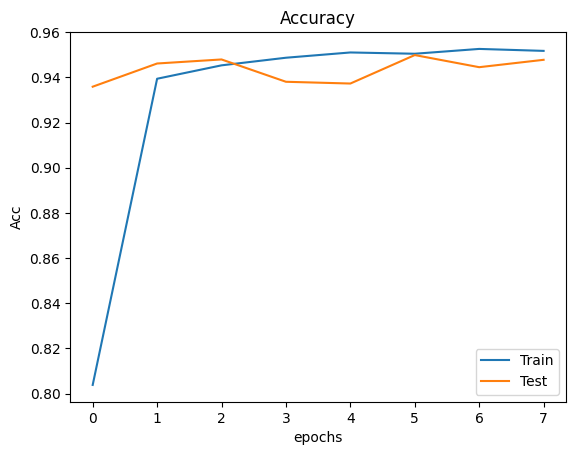

In [ ]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

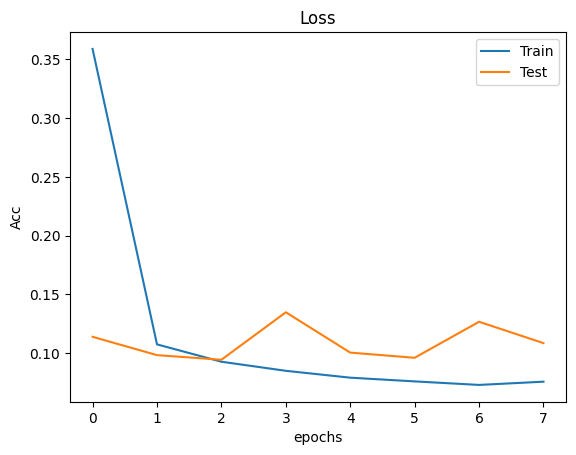

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()